In [1]:
#Import required libraries
import pyodbc # SQL library
import pandas as pd # Dataframes
import numpy as np # Arrays
import matplotlib.pyplot as plt #Graphs
from datetime import date
import ydata_profiling
import plotly.offline as po
import plotly.graph_objs as go
%matplotlib inline
plt.style.use('ggplot') #gglot style
import seaborn as sns #Enhanced plot library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler # To scale data
from sklearn.cluster import KMeans #K-means clustering
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split  # To randomly split the dataset
### from xverse.transformer import WOE # To perform Weight of Evidence for feature selection
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import accuracy_score # Accuracy for model assessment
from sklearn.feature_selection import RFE # Recursive Feature Elimination 
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier #Extra Trees
from sklearn.feature_selection import SelectKBest, chi2 # K best and Chi squre
from sklearn.svm import LinearSVC #Linear SVC for L1 featrue selection 
from sklearn.feature_selection import SelectFromModel #L1 feature selection 
from functools import reduce # To merge dataframes
from statsmodels.stats.outliers_influence import variance_inflation_factor #Multicollinearity check
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting
from sklearn.metrics import fbeta_score #fbeta score for model assessment
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.neural_network import MLPClassifier #Newral Network
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.preprocessing import MinMaxScaler #To scale data for SVC
from sklearn.svm import SVC #Support Vector Machine
from sklearn.model_selection import validation_curve, StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report # For model evaluation 
import joblib
#from sklearn.externals import joblib # To save the final model
import mlxtend as ml #Market Basket Analysis
from mlxtend.frequent_patterns import apriori # To extract frequent itemsets for MBA
from mlxtend.frequent_patterns import association_rules # To create the MBA rules
from datetime import timedelta #To define potential churn date
from warnings import simplefilter #Warning filter
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report


In [2]:
# iGNORING THE WARNINGS
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
#Connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-FUL87PF;'
                      'Database=WideWorldImporters;'
                      'Trust_Connection= yes;')


In [4]:
#SQL query; Transactional data
data=pd.read_sql_query("""SELECT 
WS.[StockItemID] AS ProductId,
PPO.[PurchaseOrderID],
ASP.[StateProvinceID],
PS.[SupplierID],
WS.[StockItemName] AS Product,
WSG.[StockGroupName] AS Product_Cat,
PPO.[OrderDate],
WS.[QuantityPerOuter],
WSI.[QuantityOnHand],
POL.[OrderedOuters] AS OrderedQty,
ASP.[StateProvinceName]
FROM [Warehouse].[StockItems] AS WS
LEFT JOIN [Purchasing].[Suppliers] AS PS
ON WS.SupplierID = PS.SupplierID
LEFT JOIN [Warehouse].[StockItemHoldings] AS WSI
ON WS.[StockItemID]=WSI.[StockItemID]
LEFT JOIN[Application].[Cities] AS AC
ON PS.[PostalCityID]= AC.[CityID]
LEFT JOIN [Application].[StateProvinces] AS ASP
ON AC.[StateProvinceID]=ASP.[StateProvinceID]
LEFT JOIN [Warehouse].[StockItemStockGroups] AS WSS
ON WS.[StockItemID]=WSS.[StockItemID]
LEFT JOIN [Warehouse].[StockGroups] AS WSG
ON WSS.[StockGroupID]=WSG.[StockGroupID]
LEFT JOIN [Purchasing].[PurchaseOrders] AS PPO
ON PS.[SupplierID] = PPO.[SupplierID]
LEFT JOIN [Purchasing].[PurchaseOrderLines] AS POL
ON PPO.[PurchaseOrderID]=POL.[PurchaseOrderID]; """, conn)

conn.close()

In [5]:
data.columns

Index(['ProductId', 'PurchaseOrderID', 'StateProvinceID', 'SupplierID',
       'Product', 'Product_Cat', 'OrderDate', 'QuantityPerOuter',
       'QuantityOnHand', 'OrderedQty', 'StateProvinceName'],
      dtype='object')

In [6]:
### Data Exploration

#Displaying first five records.
data.head()

,ProductId,PurchaseOrderID,StateProvinceID,SupplierID,Product,Product_Cat,OrderDate,QuantityPerOuter,QuantityOnHand,OrderedQty,StateProvinceName
0,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,83,Minnesota
1,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,99,Minnesota
2,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,98,Minnesota
3,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,102,Minnesota
4,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,96,Minnesota


In [7]:
#Overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089364 entries, 0 to 1089363
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   ProductId          1089364 non-null  int64 
 1   PurchaseOrderID    1089364 non-null  int64 
 2   StateProvinceID    1089364 non-null  int64 
 3   SupplierID         1089364 non-null  int64 
 4   Product            1089364 non-null  object
 5   Product_Cat        1089364 non-null  object
 6   OrderDate          1089364 non-null  object
 7   QuantityPerOuter   1089364 non-null  int64 
 8   QuantityOnHand     1089364 non-null  int64 
 9   OrderedQty         1089364 non-null  int64 
 10  StateProvinceName  1089364 non-null  object
dtypes: int64(7), object(4)
memory usage: 91.4+ MB


In [8]:
#Converting Quantity into float(useful for ML modelling later on)
data['OrderedQty']=data['OrderedQty'].astype(float)


In [9]:
data.isna().sum()

ProductId            0
PurchaseOrderID      0
StateProvinceID      0
SupplierID           0
Product              0
Product_Cat          0
OrderDate            0
QuantityPerOuter     0
QuantityOnHand       0
OrderedQty           0
StateProvinceName    0
dtype: int64

In [10]:
#Checking for potential duplicate rows
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 17550


In [11]:
data=data.drop_duplicates()

In [12]:
#Checking transaction records of one of the Products
data[data['ProductId']==1]

,ProductId,PurchaseOrderID,StateProvinceID,SupplierID,Product,Product_Cat,OrderDate,QuantityPerOuter,QuantityOnHand,OrderedQty,StateProvinceName
0,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,83.0,Minnesota
1,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,99.0,Minnesota
2,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,98.0,Minnesota
3,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,102.0,Minnesota
4,1,6,24,12,USB missile launcher (Green),Novelty Items,2013-01-01,1,175609,96.0,Minnesota
5,1,11,24,12,USB missile launcher (Green),Novelty Items,2013-01-02,1,175609,88.0,Minnesota
6,1,11,24,12,USB missile launcher (Green),Novelty Items,2013-01-02,1,175609,15.0,Minnesota
7,1,11,24,12,USB missile launcher (Green),Novelty Items,2013-01-02,1,175609,196.0,Minnesota
8,1,16,24,12,USB missile launcher (Green),Novelty Items,2013-01-03,1,175609,104.0,Minnesota
9,1,16,24,12,USB missile launcher (Green),Novelty Items,2013-01-03,1,175609,111.0,Minnesota


In [13]:
#Aggregate data per transaction 
trans_df=data.groupby(['ProductId', 'PurchaseOrderID','OrderDate']).agg({'OrderedQty':sum}).reset_index()

In [14]:
trans_df.head()

,ProductId,PurchaseOrderID,OrderDate,OrderedQty
0,1,6,2013-01-01,1434.0
1,1,11,2013-01-02,897.0
2,1,16,2013-01-03,942.0
3,1,25,2013-01-05,918.0
4,1,30,2013-01-07,594.0


In [15]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144909 entries, 0 to 144908
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ProductId        144909 non-null  int64  
 1   PurchaseOrderID  144909 non-null  int64  
 2   OrderDate        144909 non-null  object 
 3   OrderedQty       144909 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ MB


In [16]:
trans_df["OrderDate"].min(), trans_df["OrderDate"].max()

('2013-01-01', '2016-05-31')

In [17]:
import datetime as dt
TODAY = dt.datetime(2016,5,31)
trans_df["OrderDate"]=pd.to_datetime(trans_df["OrderDate"])

In [18]:
trans_df['Days_elapsed']=trans_df.groupby('ProductId')['OrderDate'].diff()

In [19]:
trans_df['Days_elapsed']=trans_df['Days_elapsed']/np.timedelta64(1,'D')

In [20]:
trans_df.head()

,ProductId,PurchaseOrderID,OrderDate,OrderedQty,Days_elapsed
0,1,6,2013-01-01,1434.0,NaN
1,1,11,2013-01-02,897.0,1.0
2,1,16,2013-01-03,942.0,1.0
3,1,25,2013-01-05,918.0,2.0
4,1,30,2013-01-07,594.0,2.0


In [21]:
aggs=['sum','mean','median','min','max']
trans_per_product = trans_df.groupby('ProductId').agg({'OrderedQty':aggs,'Days_elapsed':aggs}).reset_index()

In [22]:
trans_per_product.head()

ProductId OrderedQty                              Days_elapsed              \
                   sum   mean median    min     max          sum mean median   
0         1     4785.0  957.0  918.0  594.0  1434.0          6.0  1.5    1.5   
1         2     4785.0  957.0  918.0  594.0  1434.0          6.0  1.5    1.5   
2         3     3190.0  638.0  612.0  396.0   956.0          6.0  1.5    1.5   
3         4     4785.0  957.0  918.0  594.0  1434.0          6.0  1.5    1.5   
4         5     4785.0  957.0  918.0  594.0  1434.0          6.0  1.5    1.5   

             
   min  max  
0  1.0  2.0  
1  1.0  2.0  
2  1.0  2.0  
3  1.0  2.0  
4  1.0  2.0

In [23]:
trans=trans_per_product.drop('ProductId', axis=1)
trans.columns = ["_".join(trans) for trans in trans.columns.ravel()]
trans.head()

,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,Days_elapsed_mean,Days_elapsed_median,Days_elapsed_min,Days_elapsed_max
0,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
1,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
2,3190.0,638.0,612.0,396.0,956.0,6.0,1.5,1.5,1.0,2.0
3,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
4,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0


In [24]:
trans.insert(0, 'ProductId', trans_per_product['ProductId'])
trans.head()

,ProductId,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,Days_elapsed_mean,Days_elapsed_median,Days_elapsed_min,Days_elapsed_max
0,1,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
1,2,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
2,3,3190.0,638.0,612.0,396.0,956.0,6.0,1.5,1.5,1.0,2.0
3,4,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
4,5,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0


### Tenure and StockOut

In [25]:
#Filter relevant columns
tenure = trans_df[['ProductId','OrderDate']]
tenure = tenure.groupby('ProductId').agg({'OrderDate':['min','max']})
tenure.columns = ["_".join(tenure) for tenure in tenure.columns.ravel()]
tenure.head()

,OrderDate_min,OrderDate_max
ProductId,,
1,2013-01-01,2013-01-07
2,2013-01-01,2013-01-07
3,2013-01-01,2013-01-07
4,2013-01-01,2013-01-07
5,2013-01-01,2013-01-07


In [26]:
#Calculate tenure
tenure['Tenure_months'] = tenure['OrderDate_max']-tenure['OrderDate_min']
tenure['Tenure_months'] = tenure['Tenure_months']/np.timedelta64(1,'M')
tenure.head()

,OrderDate_min,OrderDate_max,Tenure_months
ProductId,,,
1,2013-01-01,2013-01-07,0.197129
2,2013-01-01,2013-01-07,0.197129
3,2013-01-01,2013-01-07,0.197129
4,2013-01-01,2013-01-07,0.197129
5,2013-01-01,2013-01-07,0.197129


In [27]:
tenure['Tenure_months'].describe()

count    227.000000
mean      25.620152
std       19.656545
min        0.000000
25%        0.591388
50%       40.937186
75%       40.937186
max       40.937186
Name: Tenure_months, dtype: float64

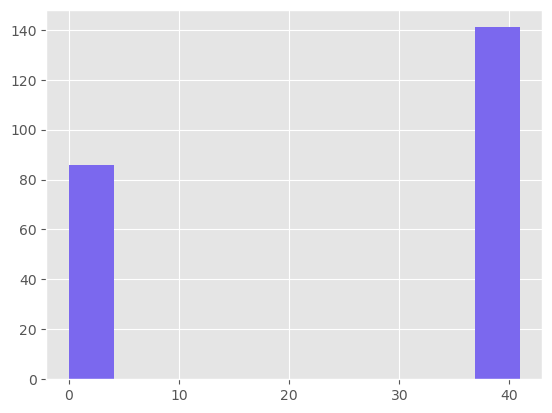

In [28]:
tenure['Tenure_months'].hist(color='mediumslateblue')
pass

In [29]:
#Calculate tenure
tenure['Tenure_days'] = tenure['OrderDate_max']-tenure['OrderDate_min']
tenure['Tenure_days'] = tenure['Tenure_days']/np.timedelta64(1,'D')
tenure.head()

,OrderDate_min,OrderDate_max,Tenure_months,Tenure_days
ProductId,,,,
1,2013-01-01,2013-01-07,0.197129,6.0
2,2013-01-01,2013-01-07,0.197129,6.0
3,2013-01-01,2013-01-07,0.197129,6.0
4,2013-01-01,2013-01-07,0.197129,6.0
5,2013-01-01,2013-01-07,0.197129,6.0


In [30]:
tenure['Tenure_days'].describe()

count     227.000000
mean      779.797357
std       598.283802
min         0.000000
25%        18.000000
50%      1246.000000
75%      1246.000000
max      1246.000000
Name: Tenure_days, dtype: float64

<AxesSubplot:>

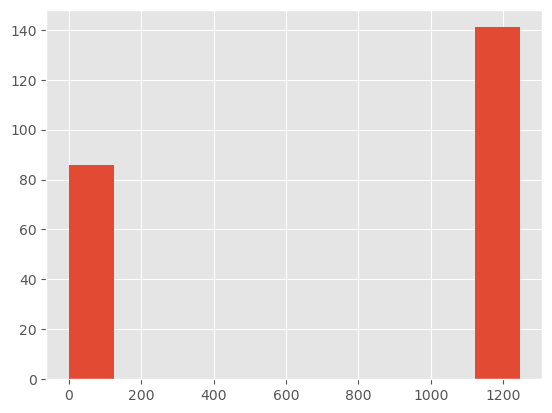

In [31]:
tenure['Tenure_days'].hist()

#### Defining Products likely to go out of Stock or not

In [32]:
StockOut_Days = 18


In [33]:
tenure["StockOut"] = tenure.Tenure_days.map(lambda val: 1 if val > StockOut_Days  else 0)

In [34]:
tenure

,OrderDate_min,OrderDate_max,Tenure_months,Tenure_days,StockOut
ProductId,,,,,
1,2013-01-01,2013-01-07,0.197129,6.0,0
2,2013-01-01,2013-01-07,0.197129,6.0,0
3,2013-01-01,2013-01-07,0.197129,6.0,0
4,2013-01-01,2013-01-07,0.197129,6.0,0
5,2013-01-01,2013-01-07,0.197129,6.0,0
...,...,...,...,...,...
223,2016-01-02,2016-01-06,0.131420,4.0,0
224,2016-01-02,2016-01-06,0.131420,4.0,0
225,2016-01-02,2016-01-06,0.131420,4.0,0


<AxesSubplot:>

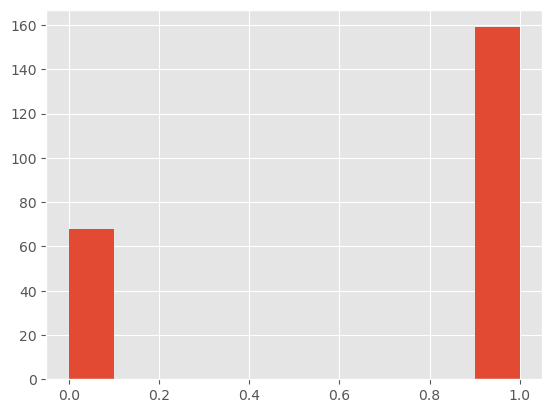

In [35]:
tenure.StockOut.hist()

In [36]:
#aother check
tenure.StockOut.value_counts()

1    159
0     68
Name: StockOut, dtype: int64

In [37]:
single_view=pd.merge(tenure,trans, on=['ProductId'])
single_view.head()

,ProductId,OrderDate_min,OrderDate_max,Tenure_months,Tenure_days,StockOut,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,Days_elapsed_mean,Days_elapsed_median,Days_elapsed_min,Days_elapsed_max
0,1,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
1,2,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
2,3,2013-01-01,2013-01-07,0.197129,6.0,0,3190.0,638.0,612.0,396.0,956.0,6.0,1.5,1.5,1.0,2.0
3,4,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0
4,5,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,1.5,1.5,1.0,2.0


In [38]:
single_view.isna().sum()

ProductId              0
OrderDate_min          0
OrderDate_max          0
Tenure_months          0
Tenure_days            0
StockOut               0
OrderedQty_sum         0
OrderedQty_mean        0
OrderedQty_median      0
OrderedQty_min         0
OrderedQty_max         0
Days_elapsed_sum       0
Days_elapsed_mean      3
Days_elapsed_median    3
Days_elapsed_min       3
Days_elapsed_max       3
dtype: int64

In [39]:
single_view.drop(['Days_elapsed_mean','Days_elapsed_median','Days_elapsed_min','Days_elapsed_max'], axis=1, inplace=True)

In [40]:
single_view.columns

Index(['ProductId', 'OrderDate_min', 'OrderDate_max', 'Tenure_months',
       'Tenure_days', 'StockOut', 'OrderedQty_sum', 'OrderedQty_mean',
       'OrderedQty_median', 'OrderedQty_min', 'OrderedQty_max',
       'Days_elapsed_sum'],
      dtype='object')

In [41]:
single_view['StateProvinceID']=data['StateProvinceID']

In [42]:
single_view

,ProductId,OrderDate_min,OrderDate_max,Tenure_months,Tenure_days,StockOut,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,StateProvinceID
0,1,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
1,2,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
2,3,2013-01-01,2013-01-07,0.197129,6.0,0,3190.0,638.0,612.0,396.0,956.0,6.0,24
3,4,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
4,5,2013-01-01,2013-01-07,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,223,2016-01-02,2016-01-06,0.131420,4.0,0,206.0,41.2,37.0,15.0,75.0,4.0,24
223,224,2016-01-02,2016-01-06,0.131420,4.0,0,206.0,41.2,37.0,15.0,75.0,4.0,24
224,225,2016-01-02,2016-01-06,0.131420,4.0,0,206.0,41.2,37.0,15.0,75.0,4.0,24
225,226,2016-01-02,2016-01-06,0.131420,4.0,0,206.0,41.2,37.0,15.0,75.0,4.0,24


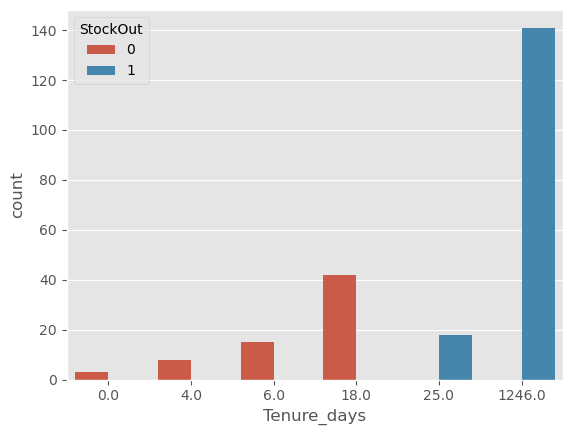

In [43]:
sns.countplot("Tenure_days", hue = "StockOut",data = single_view)
plt.show()

In [44]:
single_view.drop(['OrderDate_min','OrderDate_max'], axis = 1, inplace = True)

In [45]:
single_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 226
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductId          227 non-null    int64  
 1   Tenure_months      227 non-null    float64
 2   Tenure_days        227 non-null    float64
 3   StockOut           227 non-null    int64  
 4   OrderedQty_sum     227 non-null    float64
 5   OrderedQty_mean    227 non-null    float64
 6   OrderedQty_median  227 non-null    float64
 7   OrderedQty_min     227 non-null    float64
 8   OrderedQty_max     227 non-null    float64
 9   Days_elapsed_sum   227 non-null    float64
 10  StateProvinceID    227 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 21.3 KB


In [46]:
single_view.head()

,ProductId,Tenure_months,Tenure_days,StockOut,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,StateProvinceID
0,1,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
1,2,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
2,3,0.197129,6.0,0,3190.0,638.0,612.0,396.0,956.0,6.0,24
3,4,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
4,5,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24


###  Model Development


In [47]:
historicData=single_view

In [48]:
historicData.shape

(227, 11)

In [49]:
historicData.head()

,ProductId,Tenure_months,Tenure_days,StockOut,OrderedQty_sum,OrderedQty_mean,OrderedQty_median,OrderedQty_min,OrderedQty_max,Days_elapsed_sum,StateProvinceID
0,1,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
1,2,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
2,3,0.197129,6.0,0,3190.0,638.0,612.0,396.0,956.0,6.0,24
3,4,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24
4,5,0.197129,6.0,0,4785.0,957.0,918.0,594.0,1434.0,6.0,24


### Traning/test split/harness

In [50]:
X = historicData.drop(['StockOut', 'ProductId'], axis = 1)

In [51]:
y = historicData['StockOut']

In [52]:
RANDOM_STATE = 5

In [53]:
# b) apply a 50/50 split into training and test sets(using train_test_split)
#using train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_STATE)

Fit model - (Logistic Regression)

we use the Logistic Regression algorithm first to fit to our TRAINING data.

We train the model on ALL the features

In [54]:
# STEP 1: set up a machine learning algorithm
estimator = LogisticRegression(random_state = RANDOM_STATE)

#STEP 2: fit the model to the TRAINING set
estimator.fit(X_train, y_train)

#STEP 3: predict using the TEST set FEATURES
y_pred = estimator.predict(X_test)

#optional: extract classification probabilities for later performance metrics
y_score = estimator.predict_proba(X_test)[:0]

In [55]:
y_true = y_test # variable name change(convention) 
#for reporting metrics below

In [56]:
accuracy_score(y_true, y_pred)

1.0

In [57]:
precision_score(y_true, y_pred)

1.0

In [58]:
# d) display recall and precision
recall_score(y_true, y_pred)

1.0

In [59]:
# b) display confusion matrix results
confusion_matrix(y_true, y_pred)

array([[39,  0],
       [ 0, 75]], dtype=int64)

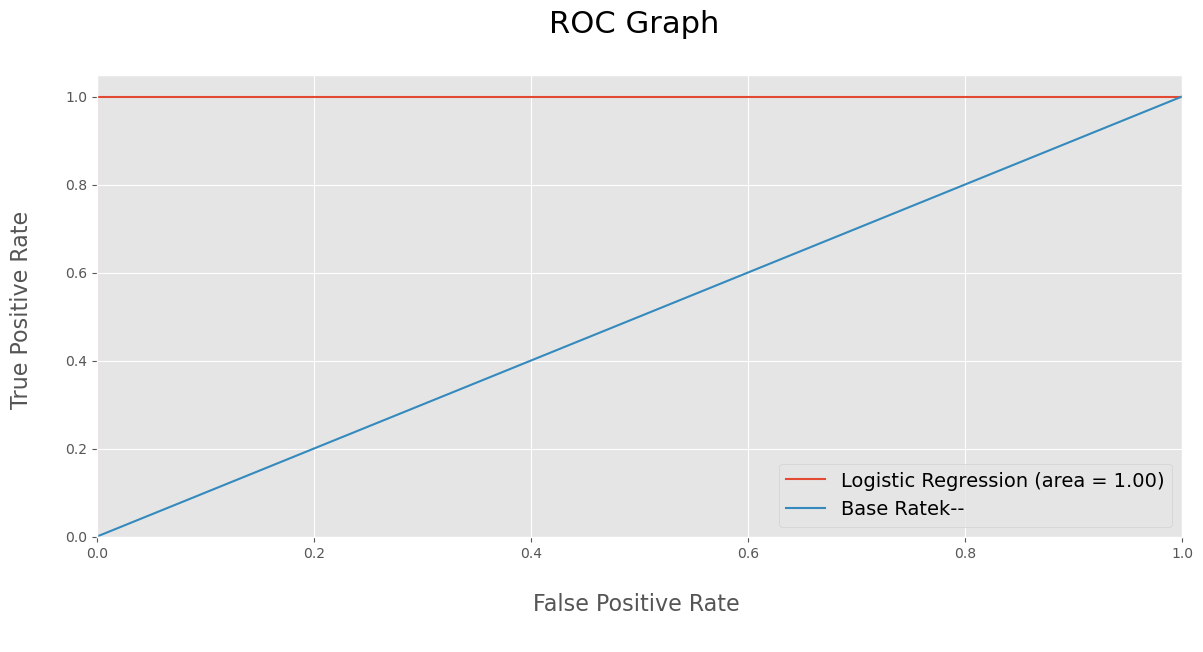

In [60]:
estimator.fit(X_train, y_train) 
probs = estimator.predict_proba(X_test) 
probs = probs[:, 1] 
estimator_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, estimator.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % estimator_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "16", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "16", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "14")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Determining the Product  propensity to go out of Stock

In [61]:
l_classifier = LogisticRegression(random_state = 0)
l_classifier.fit(X_train, y_train)
# Predict the Test set results
l_pred = l_classifier.predict(X_test)
#probability score
y_pred_probs = l_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

In [62]:
y_pred_probs

array([1.00000000e+00, 1.00000000e+00, 5.47584530e-04, 1.00000000e+00,
       5.47584530e-04, 2.21203677e-30, 1.76041687e-04, 1.00000000e+00,
       2.21203677e-30, 1.00000000e+00, 1.00000000e+00, 5.47584530e-04,
       1.00000000e+00, 5.47584530e-04, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.99999976e-01, 5.47584530e-04, 5.47584530e-04,
       9.99999976e-01, 9.99999976e-01, 5.47584530e-04, 1.00000000e+00,
       9.99999976e-01, 9.98473091e-01, 9.99999976e-01, 1.00000000e+00,
       5.47584530e-04, 5.47584530e-04, 9.98473091e-01, 1.00000000e+00,
       1.00000000e+00, 5.47584530e-04, 1.00000000e+00, 7.19330614e-03,
       1.00000000e+00, 9.99999976e-01, 1.00000000e+00, 5.47584530e-04,
       1.00000000e+00, 9.99999976e-01, 1.00000000e+00, 5.47584530e-04,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 5.47584530e-04,
       1.76041687e-04, 1.00000000e+00, 5.47584530e-04, 1.00000000e+00,
       5.47584530e-04, 1.00000000e+00, 5.47584530e-04, 1.00000000e+00,
      

In [63]:
X_test['ProductId']=historicData['ProductId']
y_test['ProductId']=historicData['ProductId']

In [64]:
test_identity = X_test['ProductId']

In [65]:
final_results = pd.concat([test_identity, y_test], axis = 1).dropna()
final_results['predictions'] = l_pred
final_results["propensity_to_GOOS(%)"] = y_pred_probs
final_results["propensity_to_GOOS(%)"] = final_results["propensity_to_GOOS(%)"]*100
final_results["propensity_to_GOOS(%)"]=final_results["propensity_to_GOOS(%)"].round(2)
final_results = final_results[['ProductId', 'StockOut', 'predictions', 'propensity_to_GOOS(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_GOOS(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
final_results.head(50)

,ProductId,StockOut,predictions,propensity_to_GOOS(%),Ranking
172,173.0,1,1,100.00,6
214,215.0,1,1,100.00,6
46,47.0,0,0,0.05,10
168,169.0,1,1,100.00,6
21,22.0,0,0,0.05,10
6,7.0,0,0,0.00,10
150,151.0,0,0,0.02,10
104,105.0,1,1,100.00,6
3,4.0,0,0,0.00,10
152,153.0,1,1,100.00,6


In [66]:
final_results.shape

(114, 5)

In [67]:
final_results.head()

,ProductId,StockOut,predictions,propensity_to_GOOS(%),Ranking
172,173.0,1,1,100.00,6
214,215.0,1,1,100.00,6
46,47.0,0,0,0.05,10
168,169.0,1,1,100.00,6
21,22.0,0,0,0.05,10


In [68]:
ProdPTGOOS=final_results[final_results['predictions']==1]

In [69]:
ProdPTGOOS.predictions.value_counts()

1    75
Name: predictions, dtype: int64

In [70]:
ProdPTGOOS.head(10)

,ProductId,StockOut,predictions,propensity_to_GOOS(%),Ranking
172,173.0,1,1,100.0,6
214,215.0,1,1,100.0,6
168,169.0,1,1,100.0,6
104,105.0,1,1,100.0,6
152,153.0,1,1,100.0,6
177,178.0,1,1,100.0,6
197,198.0,1,1,100.0,6
209,210.0,1,1,100.0,6
102,103.0,1,1,100.0,6
130,131.0,1,1,100.0,5


In [71]:
ProdPTGOOS['Product']=data['Product']
ProdPTGOOS['Product_Cat']=data['Product_Cat']

In [72]:
ProdPTGOOS.head(10)

,ProductId,StockOut,predictions,propensity_to_GOOS(%),Ranking,Product,Product_Cat
172,173.0,1,1,100.0,6,USB food flash drive - hamburger,Novelty Items
214,215.0,1,1,100.0,6,USB food flash drive - hot dog,Novelty Items
168,169.0,1,1,100.0,6,USB food flash drive - hamburger,Novelty Items
104,105.0,1,1,100.0,6,Office cube periscope (Black),Novelty Items
152,153.0,1,1,100.0,6,USB food flash drive - sushi roll,USB Novelties
177,178.0,1,1,100.0,6,USB food flash drive - hamburger,Novelty Items
197,198.0,1,1,100.0,6,USB food flash drive - hamburger,USB Novelties
209,210.0,1,1,100.0,6,USB food flash drive - hamburger,USB Novelties
102,103.0,1,1,100.0,6,Office cube periscope (Black),Novelty Items
130,131.0,1,1,100.0,5,USB food flash drive - sushi roll,Novelty Items


In [73]:
ProdPTGOOS['Propensity']=ProdPTGOOS['propensity_to_GOOS(%)']

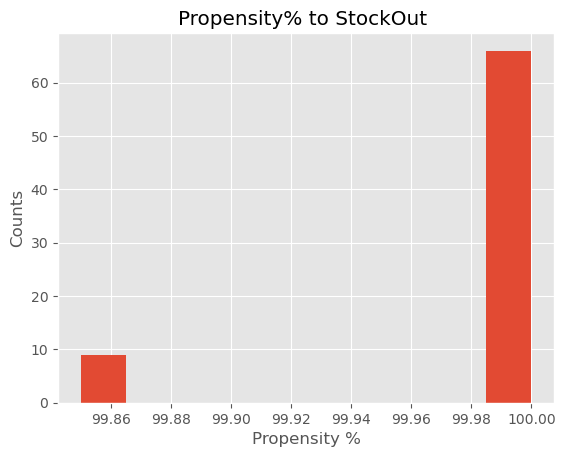

In [74]:
ProdPTGOOS.Propensity.hist()


# Adding extra features   
plt.xlabel("Propensity %")
plt.ylabel("Counts")

plt.title('Propensity% to StockOut ')
 
# Show plot
plt.show()

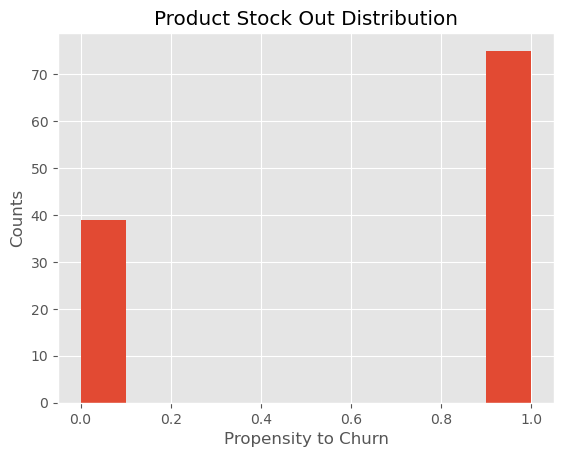

In [75]:
final_results.predictions.hist()
# Adding extra features   
plt.xlabel("Propensity to Churn")
plt.ylabel("Counts")

plt.title('Product Stock Out Distribution')
 
# Show plot
plt.show()